In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from scipy.sparse import csr_matrix
from scipy.optimize import LinearConstraint

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels as sm

from keras.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

## Прогнозирование временного ряда методами экспоненциального скользящего среднего

__Исходные данные__

In [22]:
df = pd.read_excel("D:/Datasets/regression/all_fact16-20.xlsx", engine="openpyxl")
data = df['all'].values

# 1. данные для графика (преобразуем в фрейм данных с нужным индексом)
series_graph = pd.DataFrame({'All':data[:60]}, index=pd.date_range('2016-01-31', freq='M', periods=60))
predict_series_graph = pd.DataFrame({'predict':data[60:]}, index=pd.date_range('2021-01-01', freq='M', periods=3))
# 2. данные для моделирования
data = data[:60]
data = data.reshape(-1, 1)
predict_fact = df['all'].values[60:]
predict_fact = predict_fact.reshape(-1, 1)

__Модель Тейла-Вейджа (с аддитивной сезонностью и трендом)__

In [23]:
# функция построение модели
def tail_vage(data, seasonal_periods, predict_step):
    # модель
    optimized=True
    fit_TV = ExponentialSmoothing(data, seasonal_periods=seasonal_periods, 
                                initialization_method='legacy-heuristic', 
                                trend='add', seasonal='add').fit(optimized=optimized)
    # параметры моделирования
    params = fit_TV.params
    # результат моделирования
    model_predict_TV = fit_TV.fittedvalues
    # прогноз на n шагов вперед
    pred_values_TV = fit_TV.forecast(predict_step)
    return params, model_predict_TV, pred_values_TV

seasonal_periods = 12
predict_step = 3
params, model_predict_TV, pred_values_TV = tail_vage(data, seasonal_periods, predict_step)

params, model_predict_TV, pred_values_TV

({'smoothing_level': 0.020750912577424407,
  'smoothing_trend': 0.00011288796474247606,
  'smoothing_seasonal': 0.050525231644449824,
  'damping_trend': nan,
  'initial_level': 1216.4838684171045,
  'initial_trend': -1.1924516855395764,
  'initial_seasons': array([  12.79593709,  -98.38647319,  -70.37186505, -248.78886645,
         -321.00522852, -247.06375215, -178.69271219, -191.42560958,
         -321.84749735, -194.01413323,  -74.30483185,   54.49516538]),
  'use_boxcox': False,
  'lamda': None,
  'remove_bias': False},
 array([1228.08735382, 1115.95572755, 1142.07396385,  961.68946741,
         886.95797069,  958.73536452, 1025.12463889, 1010.47828611,
         879.51361225, 1006.17770527, 1126.07582348, 1253.98933715,
        1212.92683801, 1098.85735565, 1126.60754029,  944.86831942,
         872.93257848,  946.10333613, 1011.72501234, 1000.34753011,
         868.17700769,  997.67868477, 1114.39623667, 1244.40660267,
        1199.73082422, 1086.82616289, 1108.22747466,  934.0580

__Проверка остатков на стационарность__

In [24]:
# метрика rmse оценки
def measure_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

# оценка результата моделирования
def metrics_EMA(real, forecast, fact_pred_step, pred_step):
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стационарность:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}\n\tP-значение = {:.3f}".format(dftest[0],dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные {} стационарны с вероятностью {}% процентов".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    print("Метрика модели:\nRMSE: {0}\nМетрика прогноза:\nRMSE: {1}\nПрогнозные значения: {2}".format(measure_rmse(real, forecast),
                                                                                                     measure_rmse(fact_pred_step, pred_step),
                                                                                                     pred_step))

In [25]:
metrics_result_TV = metrics_EMA(data.reshape(1,-1)[0], model_predict_TV, predict_fact.reshape(1,-1)[0], pred_values_TV)
metrics_result_TV

Тест на стационарность:
	T-статистика = -6.652
	P-значение = 0.000
Критические значения :
	1%: -3.5463945337644063 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.911939409384601 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5936515282964665 - Данные  стационарны с вероятностью 90% процентов
Метрика модели:
RMSE: 44.27216835332385
Метрика прогноза:
RMSE: 43.13242546952145
Прогнозные значения: [1156.26001003 1044.04127437 1070.6123205 ]


Тест Дики-Фуллера показывает что остатки стационарны и на определенных уровнях значимости не имеют дополнительных компонент.

<AxesSubplot:title={'center':'Модель Тейла-Вейджа'}, xlabel='Месяцы', ylabel='Потребление'>

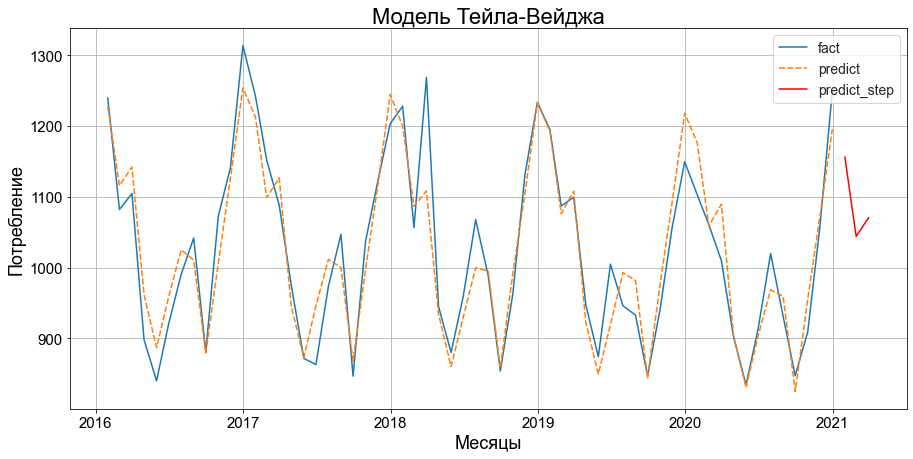

In [26]:
# задаем индекс временного ряда
index_series = pd.date_range('2016-01-31', freq='M', periods=60)
index_series_pred = pd.date_range('2021-01-01', freq='M', periods=3)

df_line = pd.DataFrame({'fact': data.reshape(1,-1)[0],
                   'predict': model_predict_TV}, index=index_series)

df_pred = pd.DataFrame({'predict_step': pred_values_TV}, index=index_series_pred)

fig, ax = plt.subplots(figsize=(15,7))
sns.set_context({'axes.labelsize': 12, 'legend.fontsize': 14})
sns.set_style('whitegrid', {'axes.grid': True})
plt.grid(True)
ax.set_title('Модель Тейла-Вейджа', fontsize=22)
plt.xlabel('Месяцы', fontsize=18)
plt.ylabel('Потребление', fontsize=18)
ax.tick_params(labelsize=15)
sns.lineplot(data=df_line)
sns.lineplot(data=df_pred, palette=['red'])

__Модель Хольта-Уинтерса (с мультипликативным трендом и аддитивной сезонностью)__ 

In [27]:
def holt_winters(data, seasonal_periods, predict_step):
    # модель
    optimized=True
    fit_HV = ExponentialSmoothing(data, seasonal_periods=12, 
                                    initialization_method='legacy-heuristic', 
                                    trend='mul', seasonal='add').fit(optimized=optimized)
    # параметры моделирования
    params = fit_HV.params
    # результат моделирования
    model_predict_HV = fit_HV.fittedvalues
    # прогноз на n шагов вперед
    pred_values_HV = fit_HV.forecast(predict_step)
    return params, model_predict_HV, pred_values_HV

seasonal_periods = 12
predict_step = 3
params, model_predict_HV, pred_values_HV = tail_vage(data, seasonal_periods, predict_step)

params, model_predict_HV, pred_values_HV

({'smoothing_level': 0.020750912577424407,
  'smoothing_trend': 0.00011288796474247606,
  'smoothing_seasonal': 0.050525231644449824,
  'damping_trend': nan,
  'initial_level': 1216.4838684171045,
  'initial_trend': -1.1924516855395764,
  'initial_seasons': array([  12.79593709,  -98.38647319,  -70.37186505, -248.78886645,
         -321.00522852, -247.06375215, -178.69271219, -191.42560958,
         -321.84749735, -194.01413323,  -74.30483185,   54.49516538]),
  'use_boxcox': False,
  'lamda': None,
  'remove_bias': False},
 array([1228.08735382, 1115.95572755, 1142.07396385,  961.68946741,
         886.95797069,  958.73536452, 1025.12463889, 1010.47828611,
         879.51361225, 1006.17770527, 1126.07582348, 1253.98933715,
        1212.92683801, 1098.85735565, 1126.60754029,  944.86831942,
         872.93257848,  946.10333613, 1011.72501234, 1000.34753011,
         868.17700769,  997.67868477, 1114.39623667, 1244.40660267,
        1199.73082422, 1086.82616289, 1108.22747466,  934.0580

In [28]:
# проверка на стационарность
metrics_result_HV = metrics_EMA(data.reshape(1,-1)[0], model_predict_HV, predict_fact.reshape(1,-1)[0], pred_values_HV)
metrics_result_HV

Тест на стационарность:
	T-статистика = -6.652
	P-значение = 0.000
Критические значения :
	1%: -3.5463945337644063 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.911939409384601 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5936515282964665 - Данные  стационарны с вероятностью 90% процентов
Метрика модели:
RMSE: 44.27216835332385
Метрика прогноза:
RMSE: 43.13242546952145
Прогнозные значения: [1156.26001003 1044.04127437 1070.6123205 ]


<AxesSubplot:title={'center':'Модель Хольта-Уинтерса'}, xlabel='Месяцы', ylabel='Потребление'>

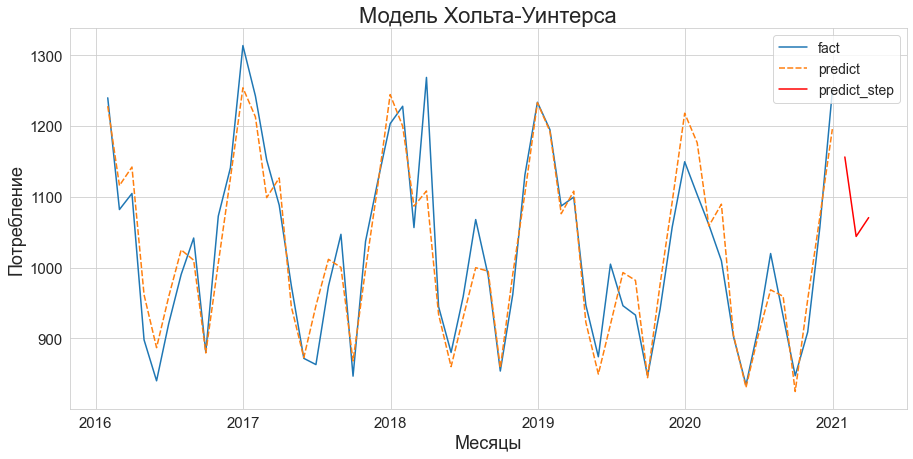

In [29]:
# задаем индекс временного ряда
index_series = pd.date_range('2016-01-31', freq='M', periods=60)
index_series_pred = pd.date_range('2021-01-01', freq='M', periods=3)

df_line = pd.DataFrame({'fact': data.reshape(1,-1)[0],
                   'predict': model_predict_HV}, index=index_series)

df_pred = pd.DataFrame({'predict_step': pred_values_HV}, index=index_series_pred)

fig, ax = plt.subplots(figsize=(15,7))
sns.set_context({'axes.labelsize': 12, 'legend.fontsize': 14})
sns.set_style('whitegrid', {'axes.grid': True})
plt.grid(True)
ax.set_title('Модель Хольта-Уинтерса', fontsize=22)
plt.xlabel('Месяцы', fontsize=18)
plt.ylabel('Потребление', fontsize=18)
ax.tick_params(labelsize=15)
sns.lineplot(data=df_line)
sns.lineplot(data=df_pred, palette=['red'])

Метрика RMSE показывает что модели Тейла-Вейджа и Хольта-Уинтерса в среднем ошибаются на 43 млн.кВт ч. Не смотрия на удовлетворительный результат, на графиках видно что обе модели недостаточно хорошо поспевают за фактическими данными в каждый момент времени. Это проглядывается как в зимний, так и летние периоды. Скачок 2018 года в зимний период практически не описывается. В летний период 2019 года происходит смещение прогноза. Для улучшения качества результата требуется:  
- больший объем исходных данных
- более устойчивый резким изменениям корректор